In [1]:
import torch
import torch.nn as nn
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import time
import os
os.environ['KMP_DUPLICATE_?LIB_OK']='True'

from dataset import *
from transforms import *
from criteria import *
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

In [2]:
# batch options 

epochs = 2

save_model = True
save_period = 1
save_loss = True

experiment_code = os.environ["EXP_CODE"]
save_root = "{}/".format(experiment_code)
log_dir = "{}/{}/".format(os.environ["CODE_ROOT"], os.environ["LOG_SUBDIR"])

model_file_template = save_root + "model_e{}.pkl"
loss_file_path = save_root + "loss.pkl"
loss_png_path = save_root + "loss.png"

status_file = save_root + "live.out"
log_file = log_dir + "{}.log".format(experiment_code)

KeyError: 'EXP_CODE'

# Datasets

In [ ]:
# ACDC

# NOTE: data stays in CPU until right before forward pass (i.e. no need for memory pinning, etc)

x_transform = torchvision.transforms.Compose([GaussianSmooth(3,1),
                                              CLAHE(clipLimit=2.0, tileGridSize=(8,8)),
                                              MinMax(),
                                              PadOrCenterCrop(size=(176,176)),
#                                               ToTensor(make_CHW=True, out_type=float)])
                                              TimeSeriesToTensor(make_TCHW=True, out_type=float)])
y_transform = torchvision.transforms.Compose([PadOrCenterCrop(size=(176,176)),
                                              ToTensor(make_CHW=False, out_type=int),
                                              SelectClass(3)])

data_dir = "ACDC_split_ts8/training_8-2/"
# data_dir = "ACDC_split/training_8-2/"
ds_train = SimpleDataset(data_dir + "x_train.txt", data_dir + "y_train.txt",
                         x_transform=x_transform, y_transform=y_transform, use_cache=True)
ds_val = SimpleDataset(data_dir + "x_val.txt", data_dir + "y_val.txt",
                         x_transform=x_transform, y_transform=y_transform, use_cache=True)

dl_train = DataLoader(ds_train, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
dl_val = DataLoader(ds_val, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
x,y = next(iter(ds_train))
print(x.shape, y.shape)

# Gamma-Net

In [ ]:
from gammanet import GammaNet

gammanet_config = GammaNet._get_default_config()
gammanet_config["input_timeseries"] = True
gammanet_config["fgru_timesteps"] = 4  # necessary for time series input

model = nn.Sequential(
#     nn.Conv2d(1, 24, 3, padding=1), # Change the number of input channels! 
#     nn.Conv2d(24, 24, 3, padding=1),
    GammaNet(gammanet_config),
    nn.ReLU(), 
    nn.BatchNorm2d(24, eps=1e-3),
    nn.Conv2d(24, 1, 5, padding=2),  # Change the expected number of output classes! 
#     nn.ReLU(),
#     nn.BatchNorm2d(2, eps=1e-3),
#     nn.Conv2d(1, 1, 1, padding=0)
)

if torch.cuda.is_available():
    model = model.cuda().float()
else:
    model = model.double()

In [ ]:
load_model = False
model_file = "models_gn_8_1-9/model_e200.pkl"
if load_model:
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_file))
    else:
        model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))

In [ ]:
model = nn.DataParallel(model)

# Training model

In [ ]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.cuda() if torch.cuda.is_available() else criterion
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.set_ylim(0,1)
hl_train, = ax.plot([], [])
hl_val, = ax.plot([], [])
hl_val_dice, = ax.plot([], [])
fig.canvas.draw()

In [ ]:
from datetime import datetime, timedelta
start_time = datetime.now()

if not os.path.exists(save_root):
    os.makedirs(save_root)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

train_loss = []
val_loss = []
val_dice = []

# epochs = 200
for epoch in range(epochs):  # loop over the dataset multiple times

    model.train()
    train_loss_epoch = []
    for i, data in enumerate(dl_train):
        inputs = data[0].cuda().float() if torch.cuda.is_available() else data[0].double()
        labels = data[1].cuda().float() if torch.cuda.is_available() else data[1].double()

        optimizer.zero_grad()
        outputs = model.forward(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_epoch += [loss.item()]

        # print statistics
        progress = (i+1 + epoch*len(dl_train)) / (epochs*len(dl_train))
        time_elapsed = datetime.now() - start_time
        time_to_completion = time_elapsed / progress - time_elapsed
        status_str = "Epoch: {}, Train, Batch {}/{}, ETA: {}".format(epoch+1, i+1, len(dl_train),
                                                                    str(time_to_completion))
        with open(status_file, 'w') as f:
            f.write(status_str)

    model.eval()
    val_loss_epoch = []
    val_dice_epoch = []
    for i, data in enumerate(dl_val):
        inputs = data[0].cuda().float() if torch.cuda.is_available() else data[0].double()
        labels = data[1].cuda().float() if torch.cuda.is_available() else data[1].double()
        
        with torch.no_grad():
            outputs = model.forward(inputs).squeeze()
            loss = criterion(outputs, labels)
            dice = dice_coeff(torch.sigmoid(outputs), labels)
        val_loss_epoch += [loss.item()]
        val_dice_epoch += [dice.item()]
        
        status_str = "Epoch: {}, Val, Batch {}/{}".format(epoch+1, i+1, len(dl_val))
        with open(status_file, 'w') as f:
            f.write(status_str)

    train_loss += [train_loss_epoch]
    val_loss += [val_loss_epoch]
    val_dice += [val_dice_epoch]
    
    # update loss graph
    hl_train.set_xdata(np.append(hl_train.get_xdata(), epoch+1))
    hl_train.set_ydata(np.append(hl_train.get_ydata(), np.mean(train_loss_epoch)))
    hl_val.set_xdata(np.append(hl_val.get_xdata(), epoch+1))
    hl_val.set_ydata(np.append(hl_val.get_ydata(), np.mean(val_loss_epoch)))
    hl_val_dice.set_xdata(np.append(hl_val_dice.get_xdata(), epoch+1))
    hl_val_dice.set_ydata(np.append(hl_val_dice.get_ydata(), np.mean(val_dice_epoch)))
    ax.legend(['Train','Val','Val_Dice']); ax.relim(); ax.autoscale(axis='x'); fig.canvas.draw()
        
    if save_model and (epoch+1) % save_period == 0:
        if isinstance(model, nn.DataParallel):
            torch.save(model.module.state_dict(), model_file_template.format(epoch+1))
        else:
            torch.save(model.state_dict(), model_file_template.format(epoch+1))
    
    progress = (epoch+1) / epochs
    time_elapsed = datetime.now() - start_time
    time_to_completion = time_elapsed / progress - time_elapsed
    summary_str = "Epoch: {}, Val Loss: {}, Val Dice: {}, ETA: {}\n"
    summary_str = summary_str.format(epoch+1, np.mean(val_loss_epoch),
                                     np.mean(val_dice_epoch), str(time_to_completion))
    print(summary_str)
    with open(log_file, 'a') as f:
        f.write(summary_str)

if save_loss:
    pickle.dump((train_loss, val_loss, val_dice), open(loss_file_path, 'wb'))
    plt.savefig(loss_png_path)

status_str = ('\nFinished Training')
print(status_str)
with open(status_file, 'w') as f:
    f.write(status_str)

In [3]:
from jupyterthemes import jtplot


In [4]:
jtplot.style()

In [5]:
import matplotlib.pyplot as plt


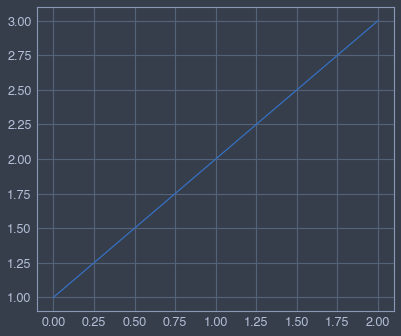

In [6]:
plt.plot([1,2,3])